In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph
import os

from common import h5dataset, onnxexporter, model_dnn, trainer


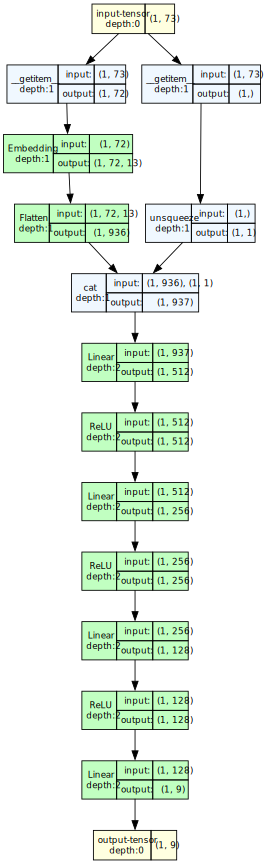

In [3]:
# Plot model graph
model = model_dnn.ModelDNNWithScore(
    name="JassPlayWithScore",
    input_size=73,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_graph = draw_graph(model, torch.zeros(1, 73).long(), show_shapes=True)
model_graph.visual_graph

In [4]:
DATASET_PATH = '../log_parser/dataset/flat_playing_with_score.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/play_with_score'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/play_with_score'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

In [5]:
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)


accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()
loss_fn = lambda y_pred, y_true: F.nll_loss(F.log_softmax(y_pred, dim=1), y_true)

# set up trainer
trainer = trainer.Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [6]:
# train the model
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
trainer.train(NUM_EPOCHS, model, optimizer)

Training model: JassPlayWithScore_512_256_128_dnn


Validation Epoch 1: 100%|██████████| 17333/17333 [01:10<00:00, 246.30it/s]


Epoch 1/20 - Train Loss: 0.8008, Train Accuracy: 66.4131, Val Loss: 0.7260, Val Accuracy: 69.7088
Model saved at epoch 1 with validation loss 0.7260


Validation Epoch 2: 100%|██████████| 17333/17333 [01:10<00:00, 245.98it/s]


Epoch 2/20 - Train Loss: 0.7031, Train Accuracy: 70.7441, Val Loss: 0.6859, Val Accuracy: 71.5706
Model saved at epoch 2 with validation loss 0.6859


Validation Epoch 3: 100%|██████████| 17333/17333 [01:08<00:00, 251.60it/s]


Epoch 3/20 - Train Loss: 0.6756, Train Accuracy: 72.0764, Val Loss: 0.6641, Val Accuracy: 72.6954
Model saved at epoch 3 with validation loss 0.6641


Validation Epoch 4: 100%|██████████| 17333/17333 [01:09<00:00, 250.33it/s]


Epoch 4/20 - Train Loss: 0.6603, Train Accuracy: 72.7809, Val Loss: 0.6621, Val Accuracy: 72.8518
Model saved at epoch 4 with validation loss 0.6621


Validation Epoch 5: 100%|██████████| 17333/17333 [01:08<00:00, 251.41it/s]


Epoch 5/20 - Train Loss: 0.6504, Train Accuracy: 73.2250, Val Loss: 0.6482, Val Accuracy: 73.3788
Model saved at epoch 5 with validation loss 0.6482


Validation Epoch 6: 100%|██████████| 17333/17333 [01:11<00:00, 241.45it/s]


Epoch 6/20 - Train Loss: 0.6424, Train Accuracy: 73.6251, Val Loss: 0.6382, Val Accuracy: 73.7559
Model saved at epoch 6 with validation loss 0.6382


Validation Epoch 7: 100%|██████████| 17333/17333 [01:12<00:00, 240.66it/s]


Epoch 7/20 - Train Loss: 0.6358, Train Accuracy: 73.9749, Val Loss: 0.6326, Val Accuracy: 74.1240
Model saved at epoch 7 with validation loss 0.6326


Validation Epoch 8: 100%|██████████| 17333/17333 [01:09<00:00, 250.30it/s]


Epoch 8/20 - Train Loss: 0.6316, Train Accuracy: 74.1994, Val Loss: 0.6367, Val Accuracy: 73.8710


Validation Epoch 9: 100%|██████████| 17333/17333 [01:07<00:00, 256.08it/s]


Epoch 9/20 - Train Loss: 0.6284, Train Accuracy: 74.3500, Val Loss: 0.6312, Val Accuracy: 74.1904
Model saved at epoch 9 with validation loss 0.6312


Training Epoch 10:  41%|████▏     | 28759/69329 [03:03<04:14, 159.45it/s]

Received signal 2, stopping training...


Validation Epoch 10: 100%|██████████| 17333/17333 [00:56<00:00, 307.66it/s]

Epoch 10/20 - Train Loss: 0.6259, Train Accuracy: 74.4644, Val Loss: 0.6304, Val Accuracy: 74.2485
Model saved at epoch 10 with validation loss 0.6304
Early stopping triggered.


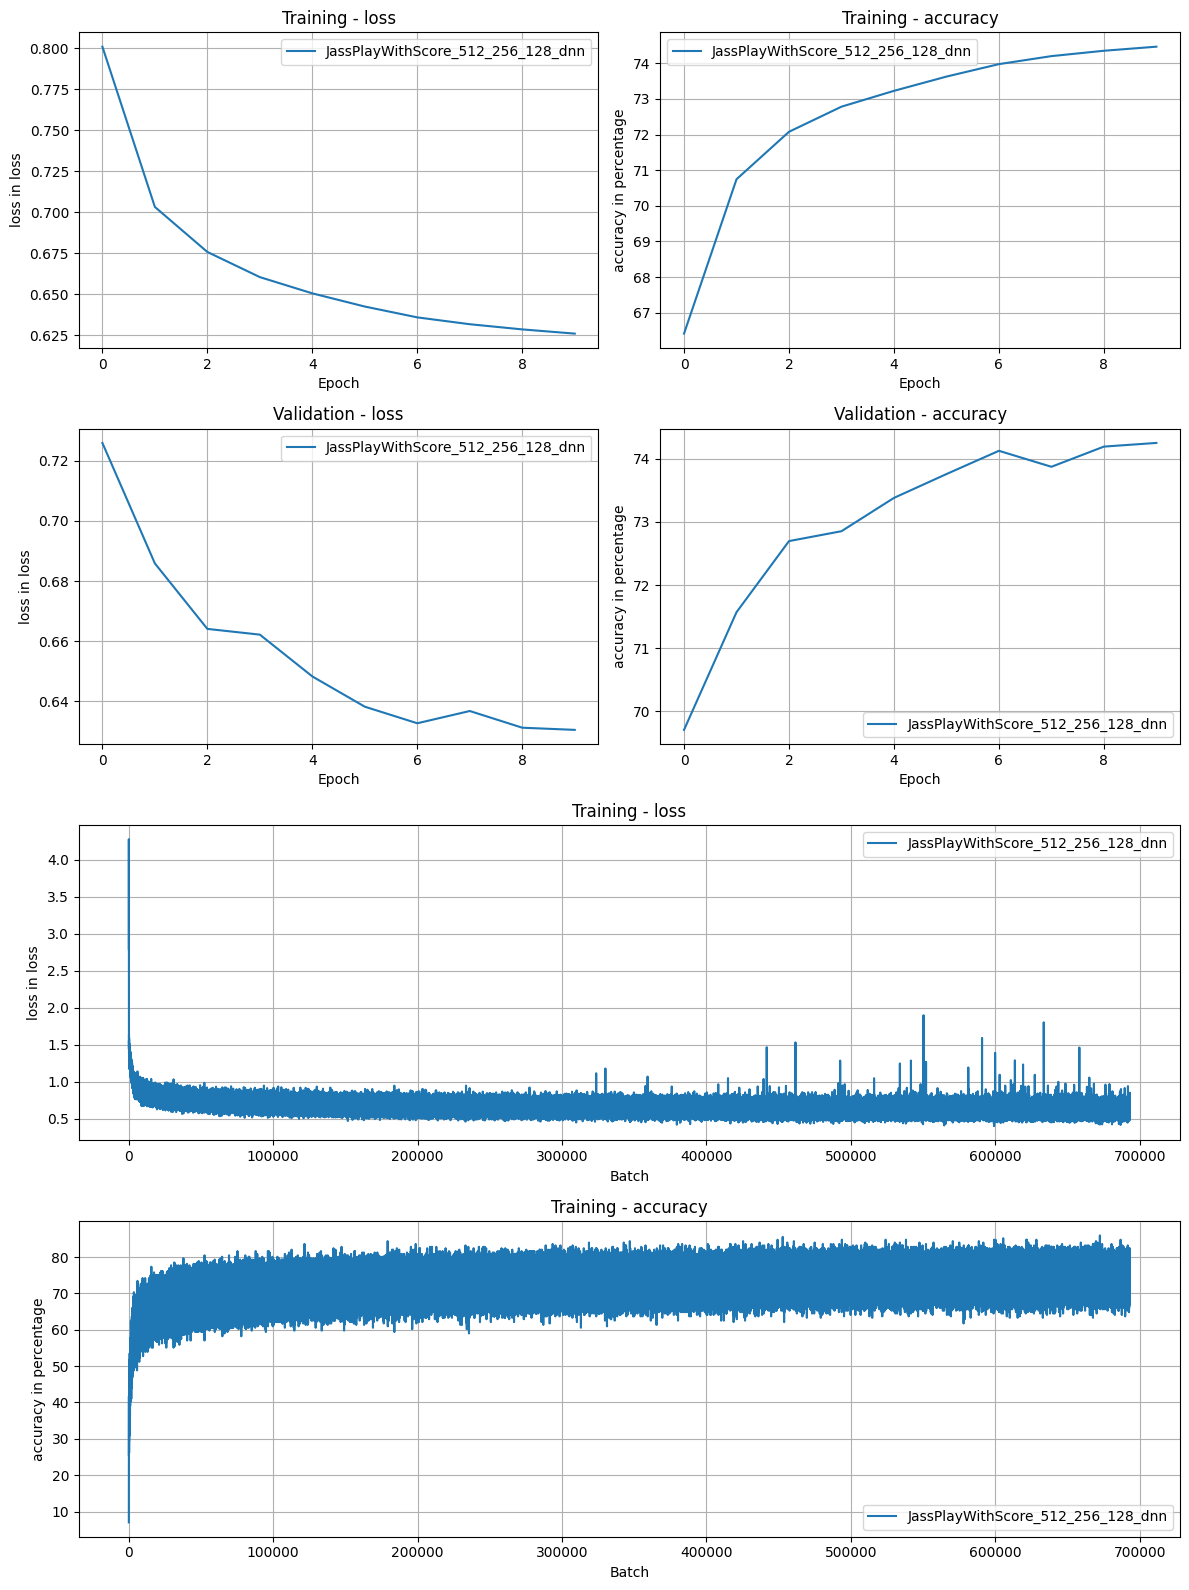

In [7]:
# create graphs
trainer.monitor.plot()

In [8]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [9]:
# export the model to ONNX
model = model.to("cpu")
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Error exporting model to ONNX: mat1 and mat2 shapes cannot be multiplied (1x924 and 937x512)
